# Kerchunk and NetCDF/HDF5:  A Case Study using the Argentinian High Resolution Weather Forecast Dataset


## Overview
   
Within this notebook, we will cover:

1. How to access remote NetCDF data using `Kerchunk`
1. Combining multiple `Kerchunk` reference files using `MultiZarrToZarr`
1. Reading the output with `Xarray` and `Intake`

This notebook shares many similarities with the [Multi-File Datasets with Kerchunk](../foundations/kerchunk_multi_file.ipynb). If you are confused on the function of a block of code, please refer there for a more detailed breakdown of what each line is doing.


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Kerchunk Basics](../foundations/kerchunk_basics) | Required | Core |
| [Multiple Files and Kerchunk](../foundations/kerchunk_multi_file) | Required | Core |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Required | IO/Visualization |
| [Intake Introduction](https://projectpythia.org/intake-cookbook/notebooks/intake_introduction.html) | Recommended | IO |
- **Time to learn**: 45 minutes
---

## Motivation

NetCDF/HDF5 is one of the most universally adopted file formats in earth sciences, with support of much of the community as well as scientific agencies, data centers and university labs. A huge amount of legacy data has been generated in this format. Fortunately, using `Kerchunk`, we can read these datasets as if they were an Analysis-Read Cloud-Optimized (ARCO) format such as `Zarr`.

## About the Dataset

The SMN-Arg is a WRF deterministic weather forecasting dataset created by the `Servicio Meteorológico Nacional de Argentina` that covers Argentina as well as many neighboring countries at a 4km spatial resolution.  
The model is initialized twice daily at 00 & 12 UTC with hourly forecasts for variables such as temperature, relative humidity, precipitation, wind direction and magnitude etc. for multiple atmospheric levels.
The data is output at hourly intervals with a maximum prediction lead time of 72 hours in NetCDF files.


More details on this dataset can be found [here](https://registry.opendata.aws/smn-ar-wrf-dataset/).


## Imports

In [1]:
import fsspec
import s3fs
import ujson
import xarray as xr
from kerchunk.combine import MultiZarrToZarr
from kerchunk.hdf import SingleHdf5ToZarr
from tqdm import tqdm

### Examining a Single NetCDF File

Before we use `Kerchunk` to create indices for multiple files, we can load a single NetCDF file to examine it. 



In [2]:
# URL pointing to a single NetCDF file
url = "s3://smn-ar-wrf/DATA/WRF/DET/2022/12/31/00/WRFDETAR_01H_20221231_00_072.nc"

# Initialize a s3 filesystem
fs = s3fs.S3FileSystem(anon=True)
# Use Xarray to open a remote NetCDF file
ds = xr.open_dataset(fs.open(url), engine="h5netcdf")

In [3]:
ds

<xarray.Dataset>
Dimensions:            (time: 1, y: 1249, x: 999)
Coordinates:
  * time               (time) datetime64[ns] 2023-01-03
  * x                  (x) float32 -1.996e+06 -1.992e+06 ... 1.992e+06 1.996e+06
  * y                  (y) float32 -2.496e+06 -2.492e+06 ... 2.492e+06 2.496e+06
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    PP                 (time, y, x) float32 ...
    T2                 (time, y, x) float32 ...
    HR2                (time, y, x) float32 ...
    dirViento10        (time, y, x) float32 ...
    magViento10        (time, y, x) float32 ...
    Lambert_Conformal  float32 ...
Attributes: (12/18)
    title:          Python PostProcessing for SMN WRF-ARW Deterministic SFC
    institution:    Servicio Meteorologico Nacional
    source:          OUTPUT FROM WRF V4.0 MODEL
    start_lat:      -54.386837
    start_lon:      -94.33081
    end_lat:        -11.645958
    ...             ...
    TRUELAT1:       -35.0
    TRUELAT2:       -35.0
    DX:             4000.0
    DY:             4000.0
    START_DATE:     2022-12-31_00:00:00
    Conventions:    CF-1.8

Here we see the `repr` from the `Xarray` Dataset of a single `NetCDF` file. From examining the output, we can tell that the Dataset dimensions are `['time','y','x']`, with time being only a single step.
Later, when we use `Kerchunk's` `MultiZarrToZarr` functionality, we will need to know on which dimensions to concatenate across. 



## Create Input File List

Here we are using `fsspec's` glob functionality along with the *`*`* wildcard operator and some string slicing to grab a list of NetCDF files from a `s3` `fsspec` filesystem. 

In [4]:
# Initiate fsspec filesystems for reading and writing
fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)
fs_write = fsspec.filesystem("")


files_paths = fs_read.glob("s3://smn-ar-wrf/DATA/WRF/DET/2023/01/26/12/*")

# Here we prepend the prefix 's3://', which points to AWS.
file_pattern = sorted(["s3://" + f for f in files_paths])

In [5]:
# This dictionary will be passed as kwargs to `fsspec`. For more details, check out the `foundations/kerchunk_basics` notebook.
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")

# We are specifiying a local output directory to write the `.json` reference files.
# Alternately, you could write these to cloud storage.
output_dir = "./"

### Optional Speedup
To speed next section up, uncomment the next cell.  This will reduce the # of input files and speed up the example considerably.    


In [6]:
file_pattern = file_pattern[0:10]

In [7]:
# Use Kerchunk's `SingleHdf5ToZarr` method to create a `Kerchunk` index from a NetCDF file.
def generate_json_reference(u, output_dir: str):
    with fs_read.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)
        fname = u.split("/")[-1].strip(".nc")
        outf = f"{fname}.json"
        with open(outf, "wb") as f:
            f.write(ujson.dumps(h5chunks.translate()).encode())
        return outf


# Iterate through filelist to generate Kerchunked files. Good use for `Dask`
output_files = []
for fil in tqdm(file_pattern):
    outf = generate_json_reference(fil, output_dir)
    output_files.append(outf)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/nrhagen/opt/anaconda3/envs/install/envs/kerchunk-cookbook-dev/lib/python3.11/site-packages/kerchunk/hdf.py:436: UserWarning: The following excepion was caught and quashed while traversing HDF5
'str' object has no attribute 'extend'
Traceback (most recent call last):
  File "/Users/nrhagen/opt/anaconda3/envs/install/envs/kerchunk-cookbook-dev/lib/python3.11/site-packages/kerchunk/hdf.py", line 379, in _translator
    za = self._zroot.create_dataset(
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nrhagen/opt/anaconda3/envs/install/envs/kerchunk-cookbook-dev/lib/python3.11/site-packages/zarr/hierarchy.py", line 975, in create_dataset
    return self._write_op(self._create_dataset_nosync, name, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nrhagen/opt/anaconda3/envs/install/envs/kerchunk-cookbook-dev/lib/python3.11/site-packages/zarr/hierarchy.py", line 827, in _write_op
    return f(*args, 

## Combine .json `Kerchunk` reference files and write a combined `Kerchunk` index

In the following cell, we are combining all the `.json` reference files that were generated above into a single reference file and writing that file to disk.

In [8]:
# combine individual references into single consolidated reference
mzz = MultiZarrToZarr(
    output_files,
    concat_dims=["time"],
    identical_dims=["y", "x"],
)
# save translate reference in memory for later visualization
multi_kerchunk = mzz.translate()

# Write kerchunk .json record
output_fname = "ARG_combined.json"
with open(f"{output_fname}", "wb") as f:
    f.write(ujson.dumps(multi_kerchunk).encode())

## Load kerchunked dataset

In [9]:
# create an fsspec reference filesystem from the Kerchunk output
fs = fsspec.filesystem("reference", fo=output_fname)
m = fs.get_mapper("")
ds = xr.open_zarr(m)

/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/ipykernel_43868/3379825023.py:4: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(m)
/Users/nrhagen/opt/anaconda3/envs/install/envs/kerchunk-cookbook-dev/lib/python3.11/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/nrhagen/opt/anaconda3/envs/install/envs/kerchunk-cookbook-dev/lib/python3.11/site-packages/xarray/coding/time

## Create a Map

Here we are using `Xarray` to select a single time slice and create a map of 2-m temperature across the region.

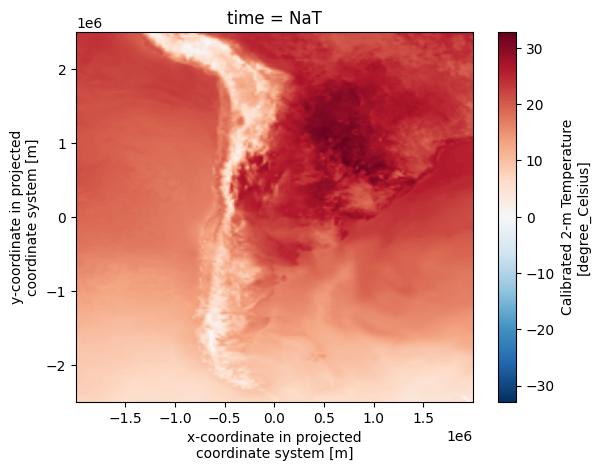

In [10]:
ds.isel(time=0).T2.plot()

## Create a Time-Series

Next we are plotting temperature as a function of time for a specific point.

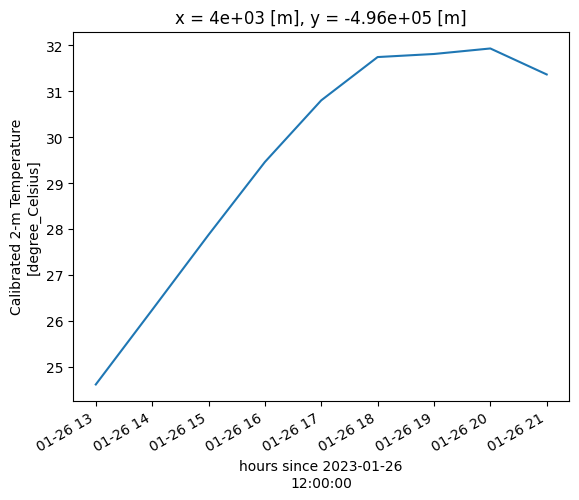

In [11]:
ds["T2"][:, 500, 500].plot()